# **Configuration**

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf


def configure_gpu(device_id: str = "0") -> None:
    """
    Configures the GPU for TensorFlow usage.

    Parameters:
    - device_id (str): The GPU device ID to use. Default is "0".

    Returns:
    - None: Prints TensorFlow version and GPU availability.
    """
    os.environ["CUDA_VISIBLE_DEVICES"] = device_id

    print(f'TensorFlow Version: {tf.__version__}')

    if tf.config.list_physical_devices('GPU'):
        print('GPU detected and configured!')
    else:
        print('No GPU found, using CPU.')


def set_random_seed(seed_value: int = 42) -> None:
    """
    Sets a fixed seed for random number generation to ensure reproducibility.

    Parameters:
    - seed_value (int): The seed value to set. Default is 42.

    Returns:
    - None: Prints confirmation of seed initialization.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    print(f'Random seed initialized to {seed_value}.')


# Initialize seed and device configuration
set_random_seed()
configure_gpu()

# **Import**

In [3]:
import math
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from ssqueezepy import ssq_stft
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from livelossplot.inputs.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# **Initialization**

In [4]:
AUTO = tf.data.AUTOTUNE

num_epochs = 15
batch_size = 32
cls_num = 5

sig_shape = (3000,)
img_shape = (12, 128, 256, 1)
overlap = 7

lr = 0.001
weight_decay = 1e-5
opt = tf.keras.optimizers.legacy.Adamax(learning_rate=lr)
los = tf.keras.losses.CategoricalCrossentropy()
mtr = ['accuracy']

NUM_LAYERS = 8
NUM_HEADS = 8
PROJECTION_DIM = 128
LAYER_NORM_EPS = 1e-6
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (img_shape[0] // PATCH_SIZE[0]) ** 2

# **Data Loader**

In [5]:
X_train = os.listdir('data/split/train-org/')
X_test = os.listdir('data/split/test-org/')
X_val = os.listdir('data/split/validation-org/')

len_tr = len(X_train)
len_ts = len(X_test)
len_vl = len(X_val)

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, path, sig_shape, img_shape, batch_size, cls_num, overlap):
        self.path = path
        self.data = os.listdir(path)
        self.sig_shape = sig_shape
        self.img_shape = img_shape
        self.batch_size = batch_size
        self.cls_num = cls_num

        self.width = img_shape[2]
        self.diff = self.width - overlap
        self.n = math.floor((sig_shape[0] - overlap) / self.diff)

        self.on_epoch_end()

    def windowing(self, signal):
        x = []
        for j in range(self.n):
            x.append(signal[self.diff * j: self.width + self.diff * j])
        return x

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.data.iloc[k] for k in indexes]
        x, y = self.__data_generation(list_IDs_temp)
        return x, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))

    def __data_generation(self, list_IDs_temp):
        x = np.empty((self.batch_size, *self.img_shape))
        y = np.empty((self.batch_size), dtype=int)
        d = np.empty((self.batch_size, *self.sig_shape))

        for i, ID in enumerate(list_IDs_temp):
            raw = np.load(os.path.join(self.path, ID))
            sig = raw['arr_0'].reshape(*self.sig_shape)
            y[i] = int(raw['arr_1'])

            sig = np.array(ID[1:3001]).reshape(*self.sig_shape)
            y[i] = int(ID[3001])

            d[i] = (sig - sig.min()) / (sig.max() - sig.min())

            all_sig = self.windowing(sig)

            for k, windowed_sig in enumerate(all_sig):
                _, TF, *_ = ssq_stft(windowed_sig.flatten())
                v = np.abs(TF)[:self.img_shape[1], :self.img_shape[2]]
                x[i, k, :, :, 0] = (v - v.min()) / (v.max() - v.min())

        return [x, d], to_categorical(y, num_classes=self.cls_num)


train_gen = DataGenerator(X_train, sig_shape, img_shape, batch_size, cls_num, overlap)
test_gen = DataGenerator(X_test, sig_shape, img_shape, batch_size, cls_num, overlap)
val_gen = DataGenerator(X_val, sig_shape, img_shape, batch_size, cls_num, overlap)

C:\Users\USER\AppData\Local\Temp\ipykernel_15732\4033318067.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y[i] = int(ID[3001])


The label is:  [1. 0. 0. 0. 0.]
The shape of the data is:  (12, 128, 256, 1)
The minimum of the data is:  0.0
The maximum of the data is:  1.0

The input data is: 



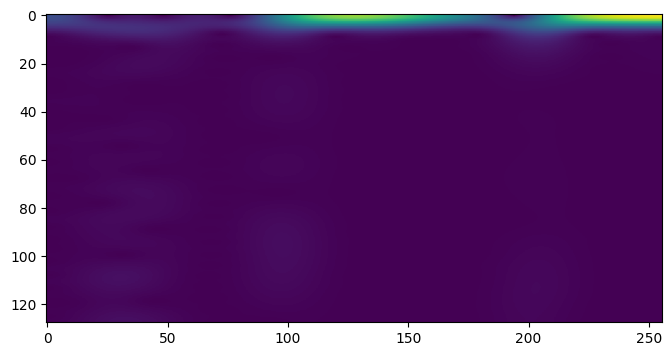

In [10]:
data_sample = next(iter(val_gen))

print('The label is: ', data_sample[1][0])
print('The shape of the data is: ', data_sample[0][0][0].shape)
print('The minimum of the data is: ', data_sample[0][0][0][0].min())
print('The maximum of the data is: ', data_sample[0][0][0][0].max())

print('\nThe input data is: \n')

plt.figure(figsize=(8, 4))
plt.imshow(data_sample[0][0][0][0])
plt.show()

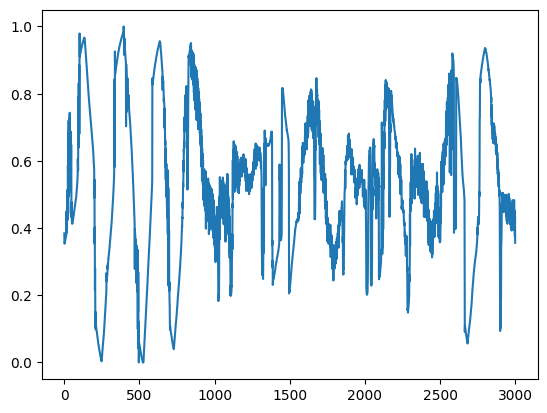

In [11]:
signal_sample = data_sample[0][1][0]

plt.plot(signal_sample)
plt.show()

# **Model**

In [12]:
def get_pretrained(path, last_layer):
    testmodel = load_model(path)
    sh_inp = testmodel.input
    sh_out = testmodel.layers[last_layer].output
    sh_model = Model(sh_inp, sh_out)
    return sh_model

In [13]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches


class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = np.arange(0, num_tokens, 1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens


def create_vivit_classifier(
        tubelet_embedder,
        positional_encoder,
        input_shape=img_shape,
        transformer_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        embed_dim=PROJECTION_DIM,
        layer_norm_eps=LAYER_NORM_EPS,
        num_classes=cls_num,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = tf.keras.Sequential(
            [
                layers.Dense(units=embed_dim * 8, activation=tf.keras.activations.gelu),
                # Increase the first layer's size
                layers.Dense(units=embed_dim * 4, activation=tf.keras.activations.gelu),  # Adjust subsequent layers
                layers.Dense(units=embed_dim, activation=tf.keras.activations.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.

    normalized_representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation_avg = layers.GlobalAvgPool1D()(normalized_representation)
    representation_max = layers.GlobalMaxPool1D()(normalized_representation)
    representation = layers.Concatenate()([representation_avg, representation_max])

    x_img = layers.Dense(64)(representation)

    fin_input = layers.Input(shape=(3000,))

    shannon_model = get_pretrained("../models/shannon_entropy", 3)
    hurst_model = get_pretrained("../models/band_power", -5)

    x_sh = shannon_model(fin_input)
    x_hu = hurst_model(fin_input)

    concat = layers.Concatenate()([x_img, x_sh, x_hu])

    # Classify outputs.
    fc = layers.Dense(units=32)(concat)
    fc = layers.Dense(units=num_classes)(fc)
    outputs = layers.Softmax()(fc)

    # Create the Keras model.
    model = tf.keras.Model(inputs=[inputs, fin_input], outputs=outputs)
    return model


model = create_vivit_classifier(tubelet_embedder=TubeletEmbedding(embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE),
                                positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM))

model.compile(optimizer=opt, loss=los, metrics=mtr)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 128, 25  0           []                               
                                6, 1)]                                                            
                                                                                                  
 tubelet_embedding (TubeletEmbe  (None, 512, 128)    65664       ['input_1[0][0]']                
 dding)                                                                                           
                                                                                                  
 positional_encoder (Positional  (None, 512, 128)    65536       ['tubelet_embedding[0][0]']      
 Encoder)                                                                                   

# **Train**

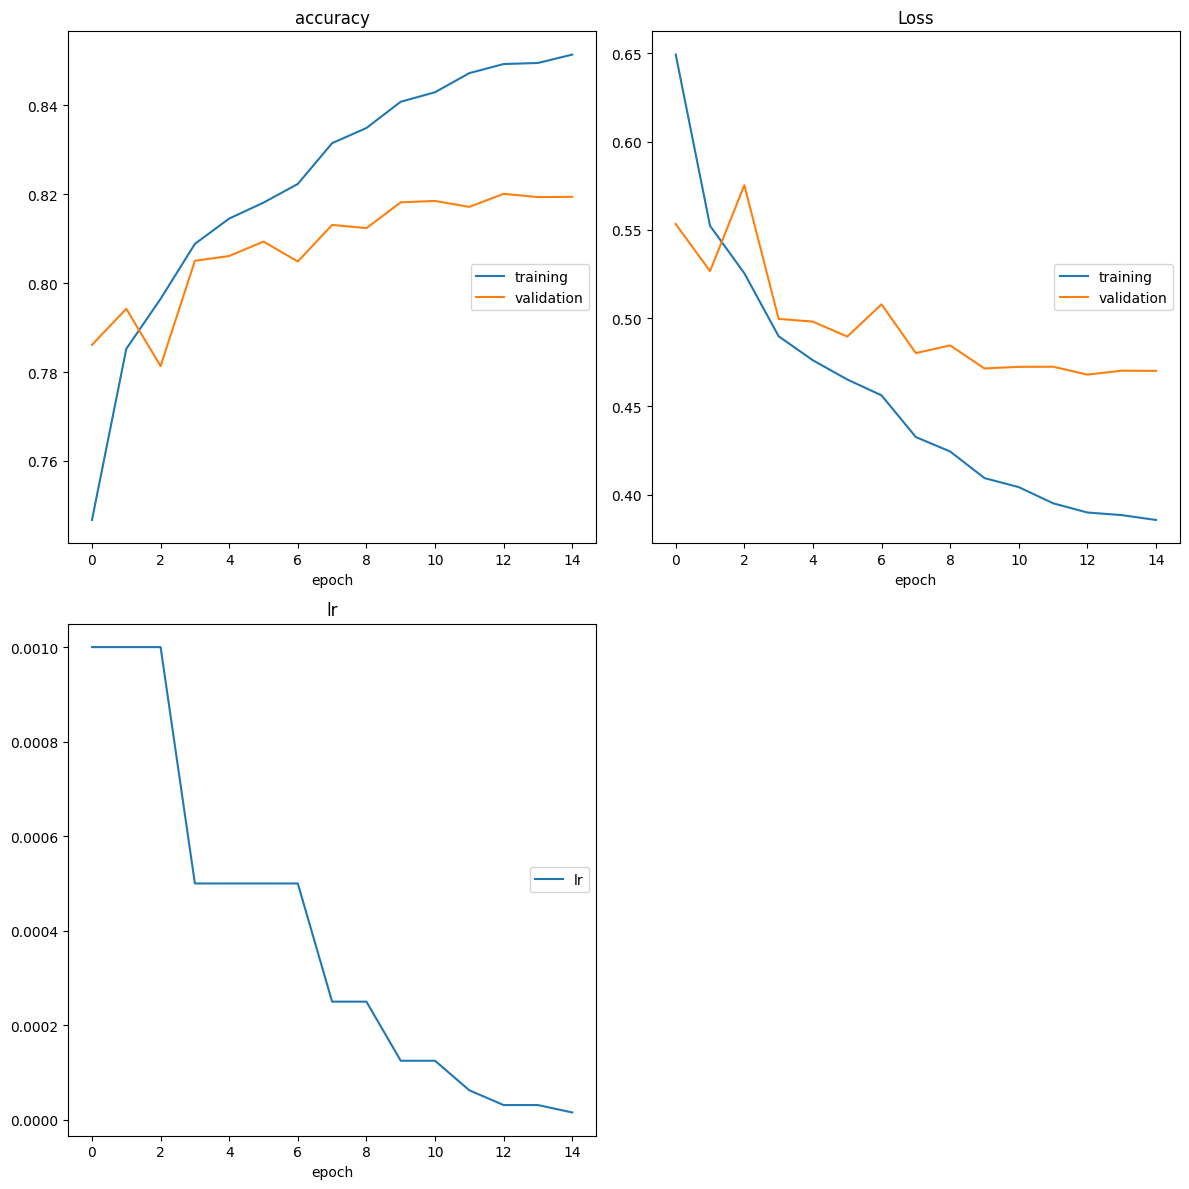

accuracy
	training         	 (min:    0.747, max:    0.851, cur:    0.851)
	validation       	 (min:    0.781, max:    0.820, cur:    0.819)
Loss
	training         	 (min:    0.386, max:    0.649, cur:    0.386)
	validation       	 (min:    0.468, max:    0.575, cur:    0.470)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
4866/4866 [==============================] - 6704s 1s/step - loss: 0.3857 - accuracy: 0.8514 - val_loss: 0.4702 - val_accuracy: 0.8194 - lr: 1.5625e-05


In [14]:
def callbacks():
    chk = ModelCheckpoint(filepath="../models/integrated", monitor='val_loss', mode='min', verbose=1,
                          save_best_only=True)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)
    vk = PlotLossesCallback()
    return [chk, rlr, vk]


history = model.fit(train_gen,
                    validation_data=val_gen,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=callbacks(),
                    steps_per_epoch=len_tr // batch_size,
                    validation_steps=len_vl // batch_size)

In [15]:
testmodel = load_model("../models/integrated")

In [16]:
def windowing(signal):
    width = img_shape[2]
    diff = width - overlap
    n = math.floor((sig_shape[0] - overlap) / diff)

    x = []
    for j in range(n):
        x.append(signal[diff * j: width + diff * j])
    return x


y_true = []
y_pred = []

for i, ID in tqdm(enumerate(X_test.iloc)):
    x = np.empty((1, *img_shape))
    sig = np.array(ID[1:3001]).reshape(*sig_shape)

    d = (sig - sig.min()) / (sig.max() - sig.min())
    d = np.expand_dims(d, axis=0)

    all_sig = windowing(sig)
    for k, windowed_sig in enumerate(all_sig):
        _, TF, *_ = ssq_stft(windowed_sig.flatten())
        v = np.abs(TF)[:img_shape[1], :img_shape[2]]
        x[0, k, :, :, 0] = (v - v.min()) / (v.max() - v.min())

    y = testmodel.predict([x, d], verbose=0)
    y_pred.append(int(np.argmax(y, axis=1)))
    y_true.append(int(ID[3001]))

0it [00:00, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_15732\1461218706.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(int(np.argmax(y, axis=1)))
C:\Users\USER\AppData\Local\Temp\ipykernel_15732\1461218706.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(int(ID[3001]))
19466it [32:21, 10.03it/s]


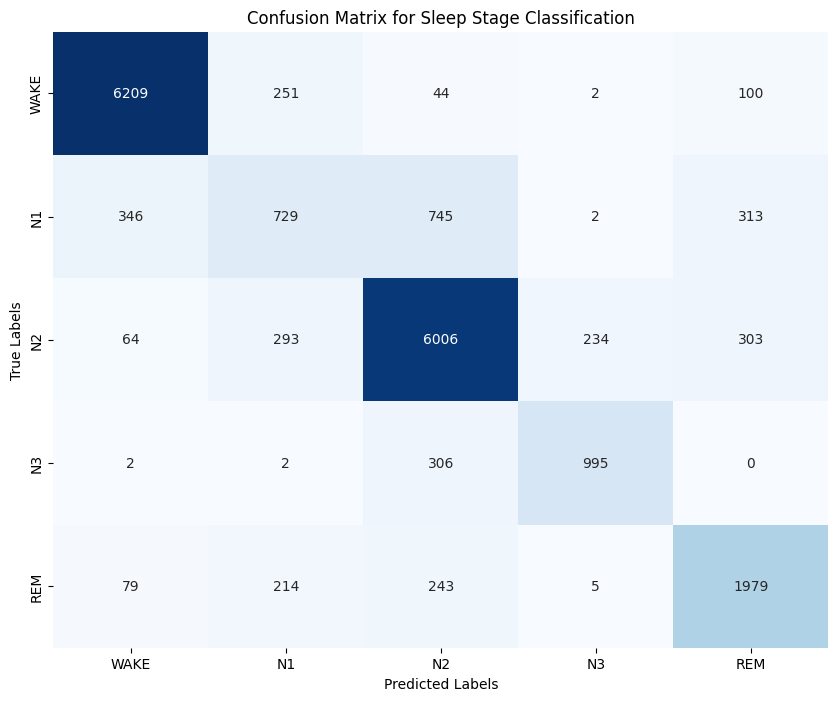

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6606
           1       0.49      0.34      0.40      2135
           2       0.82      0.87      0.84      6900
           3       0.80      0.76      0.78      1305
           4       0.73      0.79      0.76      2520

    accuracy                           0.82     19466
   macro avg       0.75      0.74      0.74     19466
weighted avg       0.81      0.82      0.81     19466



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ['WAKE', 'N1', 'N2', 'N3', 'REM']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Sleep Stage Classification')
plt.show()

print(classification_report(y_true, y_pred))

Class-wise Accuracy:
  Class  Accuracy
0  WAKE  0.939903
1    N1  0.341452
2    N2  0.870435
3    N3  0.762452
4   REM  0.785317


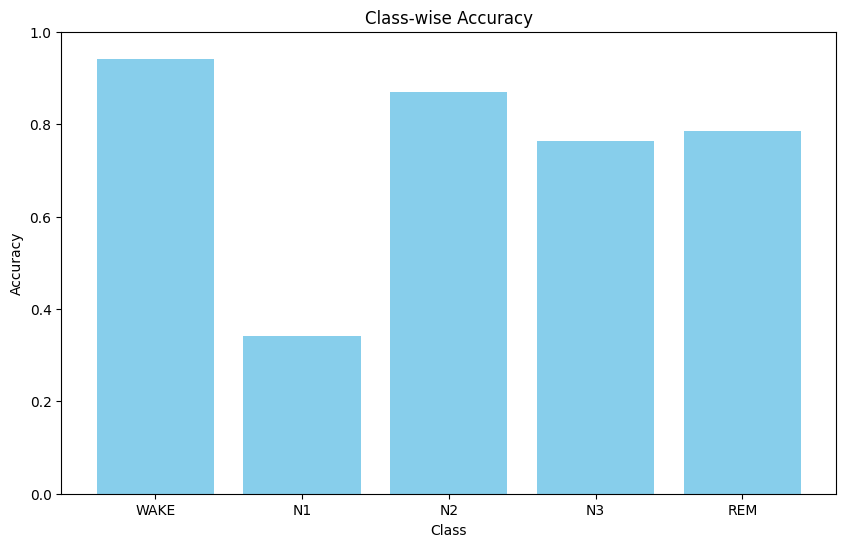

In [18]:
class_accuracies = {}
for i, class_name in enumerate(class_names):
    TP = conf_matrix[i, i]  # True positives for class i
    FN = np.sum(conf_matrix[i, :]) - TP  # False negatives for class i (sum of row - TP)
    class_accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0
    class_accuracies[class_name] = class_accuracy

# Convert to DataFrame for better readability
accuracy_df = pd.DataFrame(list(class_accuracies.items()), columns=['Class', 'Accuracy'])

print("Class-wise Accuracy:")
print(accuracy_df)

# Optional: Display accuracy as a bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(class_accuracies.keys(), class_accuracies.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()